# Classifier

In [50]:
!pip install -U git+https://github.com/platelminto/NudeNet

  Cloning https://github.com/platelminto/NudeNet to /tmp/pip-req-build-ckzffg2o
  Running command git clone --filter=blob:none --quiet https://github.com/platelminto/NudeNet /tmp/pip-req-build-ckzffg2o
  Resolved https://github.com/platelminto/NudeNet to commit 05ad8a29b4a2474e6cc4f7f76c76e77e01b08744
  Preparing metadata (setup.py) ... done
  Created wheel for NudeNetClassifier: filename=NudeNetClassifier-2.1.1-py3-none-any.whl size=154367973 sha256=028bff10f27ef69a404b019f04decc340a76588663169c1747e5de277cd3f239
  Stored in directory: /tmp/pip-ephem-wheel-cache-fdjnjez7/wheels/ff/df/3f/fe340227c75828bc5d19a59933f3f25bd59cf3fd710590aafc
Successfully built NudeNetClassifier


In [75]:
from nudenet import NudeClassifier

# initialize classifier (downloads the checkpoint file automatically the first time)
classifier = NudeClassifier()

# Classify single image
classifier.classify('/content/images (1).jpg')

{'/content/images (1).jpg': {'safe': 0.07015660405158997,
  'unsafe': 0.9298433661460876}}

# Detector

Base Classes
'EXPOSED_BELLY',
 'EXPOSED_BUTTOCKS',
 'EXPOSED_BREAST_F',
 'EXPOSED_GENITALIA_F',
 'EXPOSED_GENITALIA_M',
 'EXPOSED_BREAST_M'

In [8]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.0 MB/s eta 0:00:00


In [9]:
import onnxruntime


you can download the checkpoints from https://github.com/notAI-tech/NudeNet/releases/download/v0/detector_v2_base_checkpoint.onnx

In [96]:
model = onnxruntime.InferenceSession("/content/detector_v2_base_checkpoint.onnx")

In [17]:

import os
import cv2
import numpy as np
from PIL import Image

def read_image_bgr(path):
    """ Read an image in BGR format.
    Args
        path: Path to the image.
    """
    if isinstance(path, str):
        image = np.ascontiguousarray(Image.open(path).convert("RGB"))
    else:
        path = cv2.cvtColor(path, cv2.COLOR_BGR2RGB)
        image = np.ascontiguousarray(Image.fromarray(path))

    return image[:, :, ::-1]


def _preprocess_image(x, mode="caffe"):
    x = x.astype(np.float32)

    if mode == "tf":
        x /= 127.5
        x -= 1.0
    elif mode == "caffe":
        x -= [103.939, 116.779, 123.68]

    return x


def compute_resize_scale(image_shape, min_side=800, max_side=1333):
    (rows, cols, _) = image_shape

    smallest_side = min(rows, cols)

    scale = min_side / smallest_side

    largest_side = max(rows, cols)
    if largest_side * scale > max_side:
        scale = max_side / largest_side

    return scale


def resize_image(img, min_side=800, max_side=1333):
    scale = compute_resize_scale(img.shape, min_side=min_side, max_side=max_side)

    img = cv2.resize(img, None, fx=scale, fy=scale)

    return img, scale


def preprocess_image(
    image_path, min_side=800, max_side=1333,
):
    image = read_image_bgr(image_path)
    image = _preprocess_image(image)
    image, scale = resize_image(image, min_side=min_side, max_side=max_side)
    return image, scale

In [93]:
img , scale  = preprocess_image("/content/images (1).jpg")

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [97]:
outputs = model.run(
            [s_i.name for s_i in model.get_outputs()],
            {model.get_inputs()[0].name: np.expand_dims(img, axis=0)},
        )

In [98]:
labels = [op for op in outputs if op.dtype == "int32"][0]
scores = [op for op in outputs if isinstance(op[0][0], np.float32)][0]
boxes = [op for op in outputs if isinstance(op[0][0], np.ndarray)][0]

 https://github.com/notAI-tech/NudeNet/releases/download/v0/detector_v2_base_classes

In [66]:
classes_path = "/content/detector_v2_base_classes (1)"
classes = [c.strip() for c in open(classes_path).readlines() if c.strip()]


In [99]:
classes

['EXPOSED_BELLY',
 'EXPOSED_BUTTOCKS',
 'EXPOSED_BREAST_F',
 'EXPOSED_GENITALIA_F',
 'EXPOSED_GENITALIA_M',
 'EXPOSED_BREAST_M']

In [100]:
        boxes /= scale
        processed_boxes = []
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            if score < 0.1:
                continue
            box = box.astype(int).tolist()
            label = classes[label]
            processed_boxes.append(
                {"box": [int(c) for c in box], "score": float(score), "label": label}
            )


In [101]:
processed_boxes

[{'box': [98, 146, 150, 199],
  'score': 0.9701212644577026,
  'label': 'EXPOSED_BELLY'},
 {'box': [75, 175, 101, 223],
  'score': 0.1156005859375,
  'label': 'EXPOSED_BUTTOCKS'}]

In [102]:
img_path = "/content/images (1).jpg"

In [103]:
        image = cv2.imread(img_path)
        boxes = processed_boxes
        parts_to_blur = False
        if parts_to_blur:
            boxes = [i["box"] for i in boxes if i["label"] in parts_to_blur]
        else:
            boxes = [i["box"] for i in boxes]

        for box in boxes:
            part = image[box[1] : box[3], box[0] : box[2]]
            image = cv2.rectangle(
                image, (box[0], box[1]), (box[2], box[3]), (0, 0, 0), cv2.FILLED
            )




In [104]:
boxes

[[98, 146, 150, 199], [75, 175, 101, 223]]

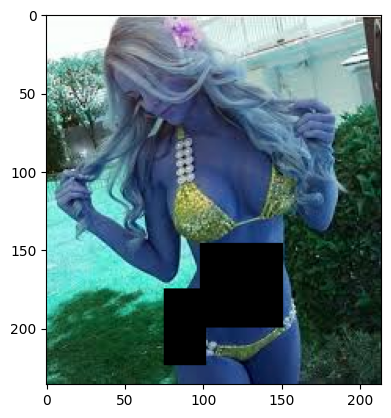

In [105]:
plt.imshow(image)

## Default Classes

In [106]:
model_2 = onnxruntime.InferenceSession("/content/detector_v2_default_checkpoint.onnx")

In [76]:
classes_path = "/content/detector_v2_default_classes"
classes_default = [c.strip() for c in open(classes_path).readlines() if c.strip()]

In [107]:
classes_default

['EXPOSED_ANUS',
 'EXPOSED_ARMPITS',
 'COVERED_BELLY',
 'EXPOSED_BELLY',
 'COVERED_BUTTOCKS',
 'EXPOSED_BUTTOCKS',
 'FACE_F',
 'FACE_M',
 'COVERED_FEET',
 'EXPOSED_FEET',
 'COVERED_BREAST_F',
 'EXPOSED_BREAST_F',
 'COVERED_GENITALIA_F',
 'EXPOSED_GENITALIA_F',
 'EXPOSED_BREAST_M',
 'EXPOSED_GENITALIA_M']

In [108]:
outputs = model_2.run(
            [s_i.name for s_i in model_2.get_outputs()],
            {model_2.get_inputs()[0].name: np.expand_dims(img, axis=0)},
        )
labels = [op for op in outputs if op.dtype == "int32"][0]
scores = [op for op in outputs if isinstance(op[0][0], np.float32)][0]
boxes = [op for op in outputs if isinstance(op[0][0], np.ndarray)][0]

In [109]:
        boxes /= scale
        processed_boxes = []
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            if score < 0.5:
                continue
            box = box.astype(int).tolist()
            label = classes_default[label]
            processed_boxes.append(
                {"box": [int(c) for c in box], "score": float(score), "label": label}
            )

In [110]:
processed_boxes

[{'box': [99, 142, 152, 194],
  'score': 0.8713813424110413,
  'label': 'EXPOSED_BELLY'},
 {'box': [73, 98, 124, 146],
  'score': 0.8693506717681885,
  'label': 'COVERED_BREAST_F'},
 {'box': [113, 206, 138, 226],
  'score': 0.8605159521102905,
  'label': 'COVERED_GENITALIA_F'},
 {'box': [119, 86, 169, 134],
  'score': 0.704248309135437,
  'label': 'COVERED_BREAST_F'}]

In [114]:
        image = cv2.imread(img_path)
        boxes = processed_boxes
        parts_to_blur = False
        if parts_to_blur:
            boxes = [i["box"] for i in boxes if i["label"] in parts_to_blur]
        else:
            boxes = [i["box"] for i in boxes]

        for box in boxes:
            part = image[box[1] : box[3], box[0] : box[2]]
            image = cv2.rectangle(
                image, (box[0], box[1]), (box[2], box[3]), (0, 0, 0), cv2.FILLED
            )



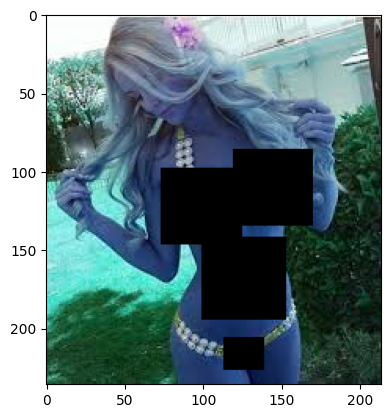

In [115]:
plt.imshow(image)